In [14]:
import numpy as np
from numpy import random
import trimesh as tri
import torch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os import listdir
from utils import mesh_processing

sphere = tri.creation.uv_sphere(count=[64, 64])
points, faces = tri.sample.sample_surface_even(sphere, count = 16*16)

transfo = np.array([[4*random.random() + 1,0,0],
                        [0,4*random.random() + 1,0],
                        [0,0,4*random.random() + 1]])
ell = transfo.dot(points.T).T

param = tri.convex.convex_hull(ell)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


(-5.0, 5.0)

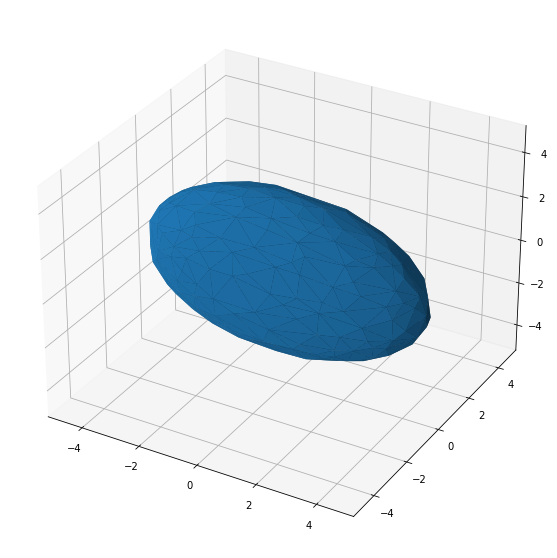

In [15]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(param.vertices[:,0], param.vertices[:,1], triangles = param.faces, Z=param.vertices[:,2])
ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)
ax1.set_zlim(-5,5)

### Shifted reparametrization

In [16]:
M = 1000
base = []
transformations = []

sphere = tri.creation.uv_sphere(count=[64, 64])
points, faces = tri.sample.sample_surface_even(sphere, count = 16*16)
sphere_sample = tri.convex.convex_hull(points)

for m in range(M):

    transfo = np.array([[4*random.random() + 1,0,0],
                        [0,4*random.random() + 1,0],
                        [0,0,4*random.random() + 1]])
    
    transformations.append(transfo)
    ell = transfo.dot(points.T).T
    param = tri.convex.convex_hull(ell)
    base.append(param)
    
base = np.array(base)
transformations = np.array(transformations)

In [17]:
alpha, beta, gamma = 0.123, -1.234, 2.345

origin, xaxis, yaxis, zaxis = [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]

Rx = tri.transformations.rotation_matrix(alpha, xaxis)
Ry = tri.transformations.rotation_matrix(beta, yaxis)
Rz = tri.transformations.rotation_matrix(gamma, zaxis)

R = tri.transformations.concatenate_matrices(Rx, Ry, Rz)

In [18]:
new_sphere = sphere_sample.apply_transform(R)
new_points = new_sphere.vertices

In [19]:
new_base = []

for m in range(M):

    transfo = transformations[m]
    
    ell = transfo.dot(new_points.T).T
    param = tri.Trimesh(vertices = ell, faces = new_sphere.faces)
    new_base.append(param)
    
new_base = np.array(new_base)

(-5.0, 5.0)

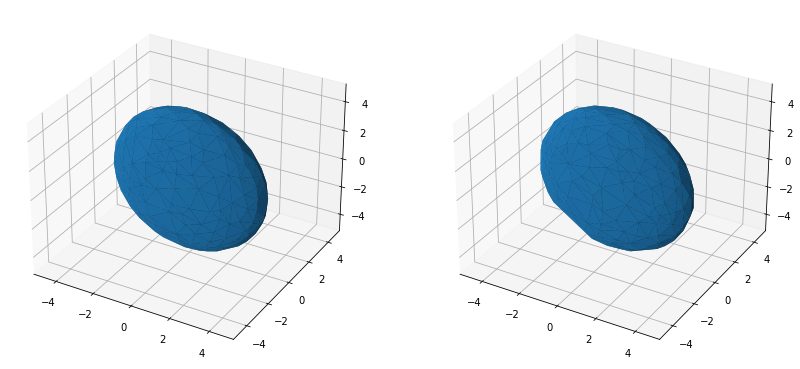

In [20]:
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(base[1].vertices[:,0], base[1].vertices[:,1], triangles = base[1].faces, Z=base[1].vertices[:,2])
ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)
ax1.set_zlim(-5,5)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(new_base[1].vertices[:,0], new_base[1].vertices[:,1], triangles = new_base[1].faces, Z=new_base[1].vertices[:,2])
ax2.set_xlim(-5,5)
ax2.set_ylim(-5,5)
ax2.set_zlim(-5,5)

### Unbalanced reparametrization

In [21]:
sphere = tri.creation.uv_sphere(count=[64, 64])
mean = sphere.area_faces.mean()
lst = [sphere.area_faces[i] + 6*mean for i in range(len(sphere.area_faces)//2)] + [sphere.area_faces[i] for i in range(len(sphere.area_faces)//2, len(sphere.area_faces))]
face_weights = np.array(lst)
points, faces = tri.sample.sample_surface(sphere, count = 16*16, face_weight=face_weights)
bad_mesh = tri.convex.convex_hull(points)

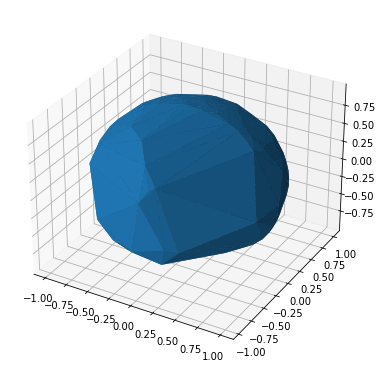

In [22]:
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(bad_mesh.vertices[:,0], bad_mesh.vertices[:,1], triangles = bad_mesh.faces, Z=bad_mesh.vertices[:,2])

In [23]:
bad_sphere = bad_mesh
bad_points = bad_sphere.vertices

bad_base = []

for m in range(M):

    transfo = transformations[m]
    
    ell = transfo.dot(bad_points.T).T
    param = tri.convex.convex_hull(ell)
    bad_base.append(param)
    
bad_base = np.array(bad_base)

(-4.0, 4.0)

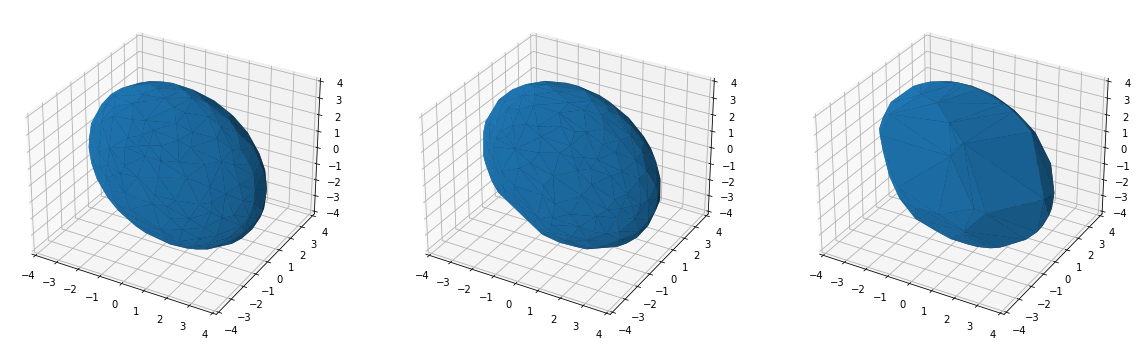

In [24]:
l = 4
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_trisurf(base[1].vertices[:,0], base[1].vertices[:,1], triangles = base[1].faces, Z=base[1].vertices[:,2])
ax1.set_xlim(-l,l)
ax1.set_ylim(-l,l)
ax1.set_zlim(-l,l)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_trisurf(new_base[1].vertices[:,0], new_base[1].vertices[:,1], triangles = new_base[1].faces, Z=new_base[1].vertices[:,2])
ax2.set_xlim(-l,l)
ax2.set_ylim(-l,l)
ax2.set_zlim(-l,l)

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_trisurf(bad_base[1].vertices[:,0], bad_base[1].vertices[:,1], triangles = bad_base[1].faces, Z=bad_base[1].vertices[:,2])
ax3.set_xlim(-l,l)
ax3.set_ylim(-l,l)
ax3.set_zlim(-l,l)

### Export ply

In [25]:
import os

if not os.path.exists("data"):
    os.mkdir("data")

if not os.path.exists("data/artificial_database"):
    os.mkdir("data/artificial_database")
    
if not os.path.exists("data/artificial_database/ref_base"):
    os.mkdir("data/artificial_database/ref_base")
    
if not os.path.exists("data/artificial_database/reparam_base"):
    os.mkdir("data/artificial_database/reparam_base")

if not os.path.exists("data/artificial_database/bad_reparam_base"):
    os.mkdir("data/artificial_database/bad_reparam_base")

In [26]:
dr = "data/artificial_database/ref_base/"

for f in os.listdir(dr):
    os.remove(os.path.join(dr, f))
    
for i, mesh in enumerate(base):
    mesh_processing.export_mesh(mesh.vertices, mesh.faces, "data/artificial_database/ref_base/" + str(i) + ".ply")

In [27]:
dr = "data/artificial_database/reparam_base/"

for f in os.listdir(dr):
    os.remove(os.path.join(dr, f))
    
for i, mesh in enumerate(new_base):
    mesh_processing.export_mesh(mesh.vertices, mesh.faces, "data/artificial_database/reparam_base/" + str(i) + ".ply")

In [28]:
dr = "data/artificial_database/bad_reparam_base/"

for f in os.listdir(dr):
    os.remove(os.path.join(dr, f))

for i, mesh in enumerate(bad_base):
    mesh_processing.export_mesh(mesh.vertices, mesh.faces, "data/artificial_database/bad_reparam_base/" + str(i) + ".ply")

In [29]:
mesh_processing.export_mesh(sphere_sample.vertices, sphere_sample.faces,
                            "data/artificial_database/" + "template.ply")